In [1]:
from tqdm import tqdm

from dataset import SummarizationDataLoader
from models import GooglePegasus, Bart, Toloka
from metrics import *

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
val_texts = open("data/reddit/arg-graph/val.source", encoding="utf-8").read().split("\n")
val_sums = open("data/reddit/arg-graph/val.target", encoding="utf-8").read().split("\n")
train_texts = open("data/reddit/arg-graph/train.source", encoding="utf-8").read().split("\n")
train_sums = open("data/reddit/arg-graph/train.target", encoding="utf-8").read().split("\n")
val_texts_2 = open("data/reddit/vanilla/val.source", encoding="utf-8").read().split("\n")
val_sums_2 = open("data/reddit/vanilla/val.target", encoding="utf-8").read().split("\n")
train_texts_2 = open("data/reddit/vanilla/train.source", encoding="utf-8").read().split("\n")
train_sums_2 = open("data/reddit/vanilla/train.target", encoding="utf-8").read().split("\n")

texts = val_texts + val_texts_2
sums = val_sums + val_sums_2

In [4]:
data = SummarizationDataLoader(texts, sums, 4)
g_metrics = {"bleu": [], "meteor": [], "source_dist": [], "target_dist": []}
t_metrics = {"bleu": [], "meteor": [], "source_dist": [], "target_dist": []}
b_metrics = {"bleu": [], "meteor": [], "source_dist": [], "target_dist": []}
embedding_score = EmbeddingScore()

In [5]:
bart = Bart()
for i in tqdm(data):    
    y_pred = bart(i["text"])
    for i, j, g in zip(y_pred, i["summarized_text"], i["text"]):
        b_metrics["bleu"].append(bleu(j, i))
        b_metrics["meteor"].append(meteor(j, i))
        b_metrics["target_dist"].append(embedding_score.calculate(j, i))
        b_metrics["source_dist"].append(embedding_score.calculate(g, i))

 15%|███████████████████████████████████▏                                                                                                                                                                                                 | 4/26 [02:03<11:31, 31.41s/it]Your max_length is set to 50, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)
Your max_length is set to 50, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)
 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 12/26 [0

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [15:39<00:00, 36.15s/it]


In [8]:
toloka = Toloka()
for i in tqdm(data):    
    y_pred = toloka(i["text"])
    for i, j, g in zip(y_pred, i["summarized_text"], i["text"]):
        t_metrics["bleu"].append(bleu(j, i))
        t_metrics["meteor"].append(meteor(j, i))
        t_metrics["target_dist"].append(embedding_score.calculate(j, i))
        t_metrics["source_dist"].append(embedding_score.calculate(g, i))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [29:16<00:00, 67.55s/it]


In [10]:
google_pegasus = GooglePegasus()
for i in tqdm(data):    
    y_pred = google_pegasus(i["text"])
    for i, j, g in zip(y_pred, i["summarized_text"], i["text"]):
        g_metrics["bleu"].append(bleu(j, i))
        g_metrics["meteor"].append(meteor(j, i))
        g_metrics["target_dist"].append(embedding_score.calculate(j, i))
        g_metrics["source_dist"].append(embedding_score.calculate(g, i))

  0%|                                                                                                                                                                                                                                             | 0/26 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (609 > 512). Running this sequence through the model will result in indexing errors
Your max_length is set to 50, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
 15%|███████████████████████████████████▏                                                                                                                                                                                                 | 4/26 [03:15<18:02, 49.19s/it]Your max_length is set to 50, but your i

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 22/26 [18:45<03:18, 49.64s/it]Your max_length is set to 50, but your input_length is only 1. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=0)
Your max_length is set to 50, but your input_length is only 1. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=0)
Your max_length is set to 50, but your input_length is only 1. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=

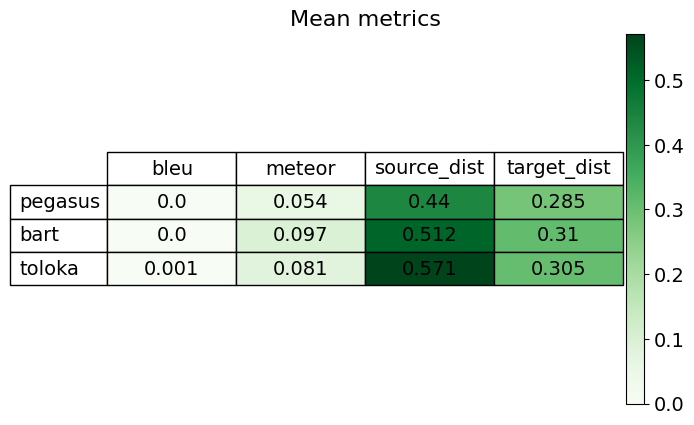

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

table = np.array([[round(sum(i[j]) / len(i[j]), 3) for j in i.keys()] for i in [g_metrics, b_metrics, t_metrics]])

norm = Normalize(vmin=table.min(), vmax=table.max())
cmap = plt.get_cmap("Greens")

fig, ax = plt.subplots()
ax.axis("off")
ax.axis("tight")

cell_colors = [[cmap(norm(val)) for val in row] for row in table]
row_labels = ["pegasus", "bart", "toloka"]
col_labels = [j for j in g_metrics.keys()]
table = ax.table(cellText=table.astype(str), cellLoc="center", colLabels=col_labels, rowLabels=row_labels, cellColours=cell_colors, loc="center",
                colWidths=[0.4, 0.4, 0.4, 0.4])

sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=ax, pad=0.2)
cbar.ax.tick_params(labelsize=14)

table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1, 2)

ax.set_title("Mean metrics", loc="center", fontsize=16)

plt.show()

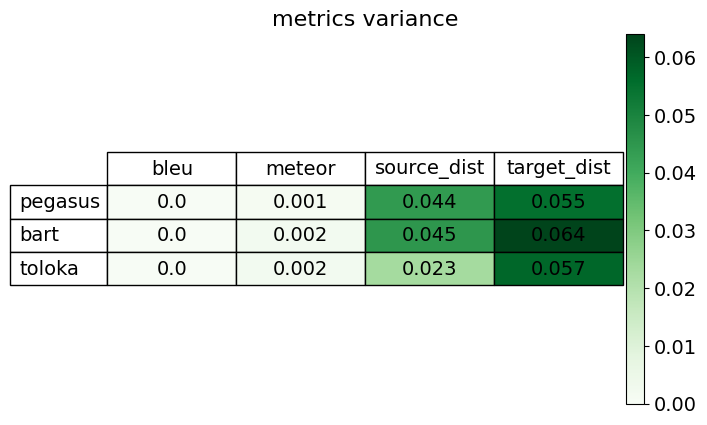

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


def var(lst):
    mean = sum(lst) / len(lst) 
    variance = sum((x - mean) ** 2 for x in lst) / (len(lst) - 1) 
    return variance


table = np.array([[round(var(i[j]), 3) for j in i.keys()] for i in [g_metrics, b_metrics, t_metrics]])

norm = Normalize(vmin=table.min(), vmax=table.max())
cmap = plt.get_cmap("Greens")

fig, ax = plt.subplots()
ax.axis("off")
ax.axis("tight")

cell_colors = [[cmap(norm(val)) for val in row] for row in table]
row_labels = ["pegasus", "bart", "toloka"]
col_labels = [j for j in g_metrics.keys()]
table = ax.table(cellText=table.astype(str), cellLoc="center", colLabels=col_labels, rowLabels=row_labels, cellColours=cell_colors, loc="center",
                colWidths=[0.4, 0.4, 0.4, 0.4])

sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=ax, pad=0.2)
cbar.ax.tick_params(labelsize=14)

table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1, 2)

ax.set_title("metrics variance", loc="center", fontsize=16)

plt.show()

In [42]:
data = SummarizationDataLoader(texts[:10], sums[:10], 4)

In [47]:
#metrics = []
toloka = Toloka()
for min_length in range(40, 55, 5):
    m = {"bleu": [], "meteor": [], "source_dist": [], "target_dist": []}
    for i in tqdm(data):    
        y_pred = toloka(i["text"], min_length, min_length + 10)
        for i, j, g in zip(y_pred, i["summarized_text"], i["text"]):
            m["bleu"].append(bleu(j, i))
            m["meteor"].append(meteor(j, i))
            m["target_dist"].append(embedding_score.calculate(j, i))
            m["source_dist"].append(embedding_score.calculate(g, i))
    metrics.append(m)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:20<00:00, 66.93s/it]


In [52]:
target_dist = [sum(i["target_dist"]) / len(i["target_dist"]) for i in metrics]
source_dist = [sum(i["source_dist"]) / len(i["source_dist"]) for i in metrics]

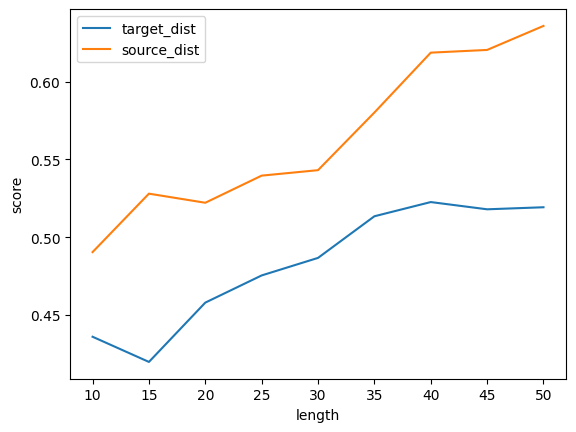

In [54]:
plt.plot(range(10, 55, 5), target_dist, label="target_dist")
plt.plot(range(10, 55, 5), source_dist, label="source_dist")
plt.xlabel("length")
plt.ylabel("score")
plt.legend()
plt.show()